In [17]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

True

### Build Child Graph

In [19]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]
    
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

In [20]:
search_tool.invoke("What is capital of France?")

[{'url': 'https://www.quora.com/What-are-the-three-official-capitals-of-France-and-which-one-is-the-most-commonly-visited',
  'content': "The capital of France is Paris. It is not only the country's capital but also its largest city and a global center for art, culture, fashion, and cuisine. Paris is home to iconic landmarks such as the Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, and the Champs-Élysées.\nApart from Paris, France has several other major cities that are significant in terms of population, economy, history, and cultural importance. Some of these major cities include: [...] 1. Marseille: Located on the Mediterranean coast, Marseille is the second-largest city in France. It is known for its vibrant multicultural atmosp\nContinue Reading\nThe capital of France is Paris. It is not only the country's capital but also its largest city and a global center for art, culture, fashion, and cuisine. Paris is home to iconic landmarks such as the Eiffel Tower, Louvre Museum, Not

In [21]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [22]:
llm_with_tools = llm.bind_tools(tools)

In [23]:
def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }
    
def tools_router(state: ChildState):
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return END     

In [24]:
tool_node = ToolNode(tools=tools)
subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")
subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

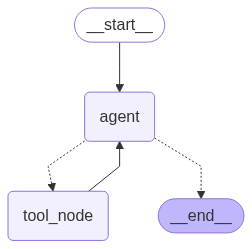

In [25]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [26]:
search_app.invoke({"messages": [HumanMessage(content="What is capital of France?")]})

{'messages': [HumanMessage(content='What is capital of France?', additional_kwargs={}, response_metadata={}, id='f17548e0-6ff3-420e-b3f4-27e3b235604a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7dk2', 'function': {'arguments': '{"query": "Capital of France"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 567, 'total_tokens': 587, 'completion_time': 0.02689306, 'prompt_time': 0.026309376, 'queue_time': -0.052012215, 'total_time': 0.053202436}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-08beb135-1754-4fa3-ab60-9cfbacf3a9b6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Capital of France'}, 'id': 'call_7dk2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 567, 'output_tokens': 20, 'total_tokens': 587}),
  ToolMessage(content='[{"url": "https:

### Case # 1: Shared Schema (Direct Emebed)

Both child and parent graph will going to share same schema and this is the communication flow between them. In this scenario, the parent graph will going to utilize childgraph as a node.

In [27]:
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

In [28]:
parent_graph = StateGraph(ParentState)
parent_graph.add_node("search_agent", search_app)

parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

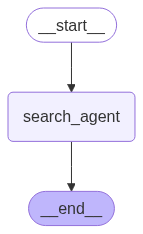

In [29]:
display(
    Image(
        parent_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [30]:
parent_app.invoke({"messages": [HumanMessage(content="What is capital of France?")]})

{'messages': [HumanMessage(content='What is capital of France?', additional_kwargs={}, response_metadata={}, id='5f46fbae-4a8b-408f-91fc-65e71bb2a0e0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7jrq', 'function': {'arguments': '{"query": "capital of France"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 284, 'total_tokens': 304, 'completion_time': 0.026666667, 'prompt_time': 0.028017452, 'queue_time': 0.213827632, 'total_time': 0.054684119}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b5460227-9024-488c-8546-4f5b66839b2c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'capital of France'}, 'id': 'call_7jrq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 284, 'output_tokens': 20, 'total_tokens': 304}),
  ToolMessage(content='[{"url": "https:

### Case # 2 - Different Schema

If we have different schema for both parent and child so we have to invoke chil from parent.

In [31]:
from typing import Dict

class QueryState(TypedDict):
    query: str
    response: str

In [32]:
def search_agent_invoker(state: QueryState):
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    subgraph_output = search_app.invoke(subgraph_input)
    assitant_message = subgraph_output["messages"][-1]
    return {"response": assitant_message.content}

In [33]:
parent_graph = StateGraph(QueryState)

parent_graph.add_node("search_agent", search_agent_invoker)

parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

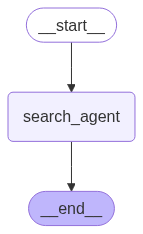

In [34]:
display(
    Image(
        parent_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [36]:
parent_app.invoke({"query": "What is capital of France?", "response": ""})

{'query': 'What is capital of France?',
 'response': 'Based on the search results, the current capital of France is Paris.'}